In [ ]:
!pip install yfinance --upgrade --no-cache-dir

In [1]:
import yfinance as yf
import pandas as pd

In [2]:
yf.__version__

'0.1.63'

In [3]:
import datetime
today = datetime.date.today().strftime('%Y-%m-%d')
today

'2021-08-14'

In [ ]:
apple = yf.Ticker('AAPL')

In [ ]:
yf.download(tickers='GOOG', period='5d')

In [ ]:
try:
    df =  yf.download("AAPL", start="2010-01-01", end="2021-07-01")
    df["Factor"] = df["Close"] / df["Adj Close"]
    print(df["Factor"].nunique(), df["Factor"].count())
except:
    print('Yahoo not working')

In [ ]:
yf.download(tickers= ["AAPL"])

In [ ]:
apple_download = yf.download(tickers = "AAPL",
            start='2014-01-01',
            end=today,
            interval='1d',
#             group_by='ticker',
            auto_adjust=False
           )

In [ ]:
apple_download.loc['2014-Jun']

In [ ]:
yf

## Try plotting with plotly

In [ ]:
df.head()

In [ ]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['Open'],
                                     high=df['High'],
                                     low=df['Low'],
                                     close=df['Adj Close'])])


fig.show()

In [ ]:
import json
import plotly

In [ ]:
json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

## Try facebook prophet

In [ ]:
apple_download = yf.download(tickers = "AAPL",
            start='2014-01-01',
            end=today,
            interval='1d',
#             group_by='ticker',
            auto_adjust=False
           )

In [ ]:
df = apple_download.copy()
df.columns = df.columns.str.replace(' ','_').str.lower()

df.head()

In [ ]:
## Fill gaps in the data
df = df.resample('D').last().ffill()

In [ ]:
fb_input = df.loc[:,['adj_close']].reset_index().rename(columns={'Date':'ds','adj_close':'y'})
fb_input.head()

In [4]:
# pip install pystan==2.18.0.0
# pip install fbprophet

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly, plot_components_plotly
import numpy as np

In [5]:
def forecast_value(df, days=180, **kwargs):
    """Create a Prophet object and create a forecast"""
    fbp = Prophet(**kwargs)
    fbp.fit(df)
    fut = fbp.make_future_dataframe(periods=days, include_history=False)
    forecast = fbp.predict(fut)
    
    return fbp, forecast


def merge_forecast(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> pd.DataFrame:
    merged = y_true.merge(y_pred, on='ds', how='left')
    merged = merged.loc[:,['ds','y','yhat']]
    
    merged['difference'] = merged['yhat']-merged['y']
    
    return merged
    

In [ ]:
fcst = forecast_value(fb_input.tail(3*365).head(3*365-180), days=180, **{'changepoint_prior_scale':0.2})
df_merged = merge_forecast(fb_input.tail(180),fcst[1])

In [ ]:
mape = 1/df_merged.shape[0]*sum(np.abs(df_merged.y-df_merged.yhat)/df_merged.y)
print(f'{mape*100:.2f}%')

What are we actually doing?
- Get ticker symbol and download data
- Adjust/clean df to fit in prophet model
- Run the model with params X and input data y
- Evaluate model using a period of data that was left out

In [6]:
def get_ticker_data(ticker_symbol: str, start_date: str='2018-01-01', end_date: str='2021-08-14') -> pd.DataFrame:
    """Retrieve the data through the yahoo finance API between start and end dates and return a pandas DataFrame with
    the adjusted close values per day. Return the dataframe with the downloaded data

    Keyword arguments:
    ticker_symbol -- Valid ticker symbol to retrieve data for
    start_date    -- Start date to retieve data for, string (default '2021-01-01')
    end_date      -- End date to retrieve data for, string (default date of today)
    """
    df =  yf.download(ticker_symbol, start=start_date, end=end_date)
        

    df.columns = df.columns.str.lower().str.replace(' ','_')

    return df

In [7]:
def create_prophet_train_test_set(df: pd.DataFrame, test_size: int = 180):
    """Take the dataframe as input, rename columns to expected ds & y value and split into train and test set"""
    
    # Fix missing data fields
    df = df.resample('D').last().ffill()
    
    split_set = (df.loc[:,['adj_close']]
                 .reset_index()
                 .rename(columns={'Date':'ds','adj_close':'y'})
                )
    train_set = split_set.iloc[:-test_size].loc[:,['ds','y']]
    test_set = split_set.iloc[-test_size:].loc[:,['ds','y']]
    
    return train_set, test_set

In [8]:
def calculate_mape_score(df):
    n = df.shape[0]
    
    abs_fractions = np.abs(df.y-df.yhat)/df.y
    
    mape = 1/n * sum(abs_fractions)
    return mape

In [12]:
ticker_list = ['AAPL','GOOG','MSFT', 'ADYEN.AS','AMZN','AGN.AS','AKZA.AS','ASML','GLPG']
mape_score = {}
ticker_object = {}

prophet_params = {'changepoint_prior_scale':0.3,
                  'yearly_seasonality':'auto',
                  'seasonality_prior_scale':2,
                  'daily_seasonality': False,
                  'changepoint_range': 0.9
                 }

for ticker in ticker_list:
    print(f'Forecasting for {ticker}')

        
    ticker_data = ticker_object.get(ticker,{}).get('ticker_data', pd.DataFrame())
    if ticker_data.empty:
        # Get ticker data
        print('\tDownloading ticker data')
        ticker_data = get_ticker_data(ticker, start_date='2018-08-15',end_date='2021-08-14')

    # Split in train and test set
    print('\tSplitting data in train and test')
    ticker_train_data, ticker_test_data = create_prophet_train_test_set(ticker_data)

    print('\tTraining the model and predicting the future')
    # Train model and predict the future
    model, fcst = forecast_value(ticker_train_data, days=180, **prophet_params)

    print('\tEvaluating the model')
    # evaluate the prediction
    evaluation_df = (ticker_test_data.merge(fcst, on='ds', how='left')
                      .loc[:,['ds','y','yhat']]
                     )
    mape_score[ticker] = calculate_mape_score(evaluation_df)

    ticker_object[ticker] = {'mape_score': calculate_mape_score(evaluation_df),
                             'model': model,
                             'forecast': fcst,
                             'ticker_data':ticker_data
                            }
#     except:
#         print(f'Couldnt complete forecast for {ticker}')
#         continue
    

Forecasting for AAPL
[*********************100%***********************]  1 of 1 completed
	Splitting data in train and test
	Training the model and predicting the future
	Evaluating the model
Forecasting for GOOG
[*********************100%***********************]  1 of 1 completed
	Splitting data in train and test
	Training the model and predicting the future
	Evaluating the model
Forecasting for MSFT
[*********************100%***********************]  1 of 1 completed
	Splitting data in train and test
	Training the model and predicting the future
	Evaluating the model
Forecasting for ADYEN.AS
[*********************100%***********************]  1 of 1 completed
	Splitting data in train and test
	Training the model and predicting the future
	Evaluating the model
Forecasting for AMZN
[*********************100%***********************]  1 of 1 completed
	Splitting data in train and test
	Training the model and predicting the future
	Evaluating the model
Forecasting for AGN.AS
[************

{'AAPL': 0.03471842225095009,
 'GOOG': 0.07966393685177674,
 'MSFT': 0.09845092690929938,
 'ADYEN.AS': 0.4449757659007981,
 'AMZN': 0.06882476844046866,
 'AGN.AS': 0.16490292798052625,
 'AKZA.AS': 0.3782512728262381,
 'ASML': 0.07781325828431969,
 'GLPG': 0.2968439387815376}

In [13]:
mape_score

{'AAPL': 0.044312549251755595,
 'GOOG': 0.06835271013821041,
 'MSFT': 0.10190913219668063,
 'ADYEN.AS': 0.35829659527266355,
 'AMZN': 0.08378744654046345,
 'AGN.AS': 0.16892317377228658,
 'AKZA.AS': 0.3565058747498209,
 'ASML': 0.08702958791899369,
 'GLPG': 0.17467804933325812}

<AxesSubplot:xlabel='ds'>

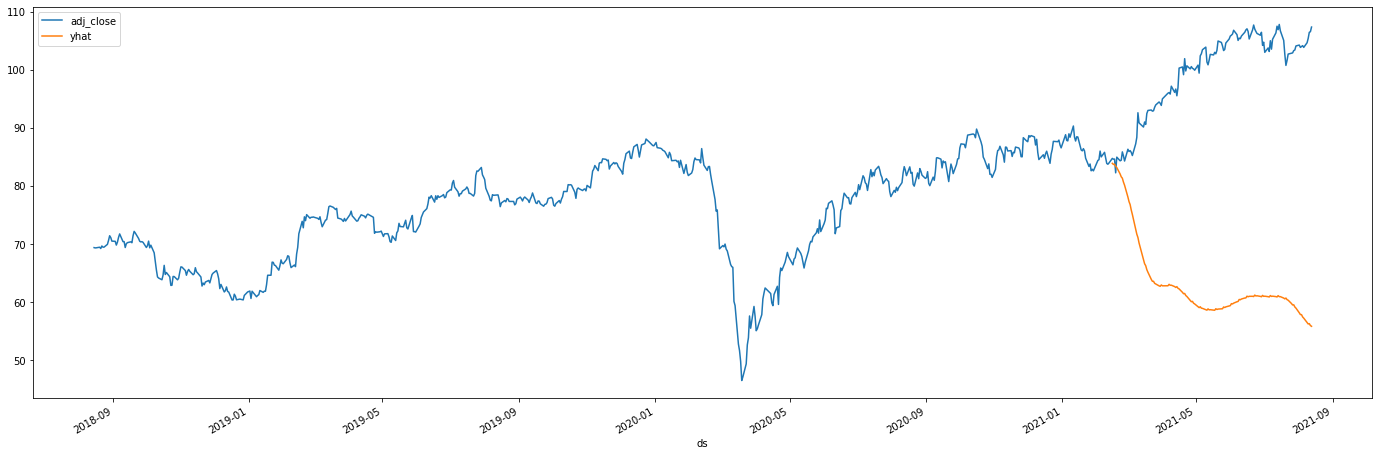

In [14]:
g_mape, g_model, g_forecast, g_ticker_data = ticker_object['AKZA.AS'].values()
g_ticker_data.merge(g_forecast, left_index=True, right_on ='ds', how='left').set_index('ds')[['adj_close','yhat']].plot(figsize=(24,8))

## Do a Grid search

In [21]:
def run_forecast(ticker_object: dict = {}, params: dict = {}):
    mape_score = {}
    
    for ticker in ticker_list:
        ticker_data = ticker_object.get(ticker,{}).get('ticker_data', pd.DataFrame())
        if ticker_data.empty:
            # Get ticker data
            print('\tDownloading ticker data')
            ticker_data = get_ticker_data(ticker, start_date='2018-08-15',end_date='2021-08-14')

        # Split in train and test set
        print('\tSplitting data in train and test')
        ticker_train_data, ticker_test_data = create_prophet_train_test_set(ticker_data)

        print(f'\tTraining the model and predicting the future\nwith params{params}')
        # Train model and predict the future
        model, fcst = forecast_value(ticker_train_data, days=180, **params)

        print('\tEvaluating the model')
        # evaluate the prediction
        evaluation_df = (ticker_test_data.merge(fcst, on='ds', how='left')
                          .loc[:,['ds','y','yhat']]
                         )
        mape_score[ticker] = calculate_mape_score(evaluation_df)

#         ticker_object[ticker] = {'mape_score': calculate_mape_score(evaluation_df),
#                                  'model': model,
#                                  'forecast': fcst,
#                                  'ticker_data':ticker_data
#                                 }
        
    return mape_score

In [22]:
from sklearn.model_selection import ParameterGrid

In [23]:
gridsearch = {}
prophet_param_grid = ParameterGrid({'changepoint_prior_scale':[i/100 for i in range(5,55,10)],
                  'yearly_seasonality':['auto'],
                  'seasonality_prior_scale':[2,5,10,20],
                  'daily_seasonality': [False],
                  'changepoint_range': [0.8, 0.9, 1.0]
                 })

for params in prophet_param_grid:
    name = f"{params.get('changepoint_prior_scale')}_{params.get('changepoint_range')}_{params.get('seasonality_prior_scale')}"
    print(f'Param overview: {name}')
    
    gridsearch[name] = run_forecast(ticker_object, params)
    
    

# for ticker in ticker_list:
#     print(f'Forecasting for {ticker}')


Param overview: 0.05_0.8_2
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonalit

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 10, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 10, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 10, 'yearly_seasonality': 'auto'}
	Evaluating the model
Param overview: 0.05_1.0_20
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.05, 'changepoint_range': 1.0, 'daily_season

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.15, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 10, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.15, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 10, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.15, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 10, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.15, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.15, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 5, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.15, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 5, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.15, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 5, 'yearly_seasonality': 'auto'}
	Evaluating the model
Param overview: 0.15_0.9_10
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.15, 'changepoint_range': 0.9, 'daily_seasonali

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.15, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 5, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.15, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 5, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.15, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 5, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.15, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_pri

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
Param overview: 0.25_0.8_5
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 0.8, 'daily_seasonalit

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_pri

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
Param overview: 0.25_1.0_2
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 1.0, 'daily_seasona

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.25, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.35, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 10, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.35, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 10, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.35, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 10, 'yearly_seasonality': 'auto'}
	Evaluating the model
Param overview: 0.35_0.8_20
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.35, 'changepoint_range': 0.8, 'daily_season

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.35, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 10, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.35, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 10, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.35, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 10, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.35, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.35, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 5, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.35, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 5, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.35, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 5, 'yearly_seasonality': 'auto'}
	Evaluating the model
Param overview: 0.35_1.0_10
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.35, 'changepoint_range': 1.0, 'daily_seasonali

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 5, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 5, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_prior_scale': 5, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 0.8, 'daily_seasonality': False, 'seasonality_pri

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 0.9, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
Param overview: 0.45_0.9_5
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 0.9, 'daily_seasonalit

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 2, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_pri

	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model
	Splitting data in train and test
	Training the model and predicting the future
with params{'changepoint_prior_scale': 0.45, 'changepoint_range': 1.0, 'daily_seasonality': False, 'seasonality_prior_scale': 20, 'yearly_seasonality': 'auto'}
	Evaluating the model


In [24]:
gridsearch

{'0.05_0.8_2': {'AAPL': 0.10524354745155594,
  'GOOG': 0.08750861775541896,
  'MSFT': 0.03052048127052731,
  'ADYEN.AS': 0.09515217883932119,
  'AMZN': 0.08476219725889582,
  'AGN.AS': 0.10588546370473464,
  'AKZA.AS': 0.22447438584012722,
  'ASML': 0.043357754355272345,
  'GLPG': 0.4212894372749861},
 '0.05_0.8_5': {'AAPL': 0.10363251694526851,
  'GOOG': 0.08425576738806635,
  'MSFT': 0.029420921109969685,
  'ADYEN.AS': 0.09394344739598186,
  'AMZN': 0.08781614109639901,
  'AGN.AS': 0.10402826400349409,
  'AKZA.AS': 0.18920930357194216,
  'ASML': 0.04344334838677739,
  'GLPG': 0.44582175069011865},
 '0.05_0.8_10': {'AAPL': 0.10923094499471561,
  'GOOG': 0.0896918864902039,
  'MSFT': 0.029530329654391802,
  'ADYEN.AS': 0.0923624959320224,
  'AMZN': 0.08703138758526956,
  'AGN.AS': 0.10394719417836944,
  'AKZA.AS': 0.20596517780721604,
  'ASML': 0.04383628564497393,
  'GLPG': 0.46416462443728146},
 '0.05_0.8_20': {'AAPL': 0.10639084179917742,
  'GOOG': 0.0943440049735579,
  'MSFT': 0.03

In [29]:
grid_df = pd.DataFrame(gridsearch).T
grid_df.head()

,AAPL,GOOG,MSFT,ADYEN.AS,AMZN,AGN.AS,AKZA.AS,ASML,GLPG
0.05_0.8_2,0.105244,0.087509,0.030520,0.095152,0.084762,0.105885,0.224474,0.043358,0.421289
0.05_0.8_5,0.103633,0.084256,0.029421,0.093943,0.087816,0.104028,0.189209,0.043443,0.445822
0.05_0.8_10,0.109231,0.089692,0.029530,0.092362,0.087031,0.103947,0.205965,0.043836,0.464165
0.05_0.8_20,0.106391,0.094344,0.030632,0.094600,0.084919,0.104498,0.232113,0.041890,0.466309
0.05_0.9_2,0.159346,0.050062,0.025865,0.088551,0.093601,0.147027,0.233407,0.117856,0.414889


In [57]:
grid_df.to_csv('grid_search_prophet_tickers.csv', sep='\t', index=True)

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
## probably normalize the grid set
## 

In [51]:
grid_df.median()

AAPL        0.072155
GOOG        0.096244
MSFT        0.067049
ADYEN.AS    0.094103
AMZN        0.086972
AGN.AS      0.160163
AKZA.AS     0.271285
ASML        0.088146
GLPG        0.418107
dtype: float64

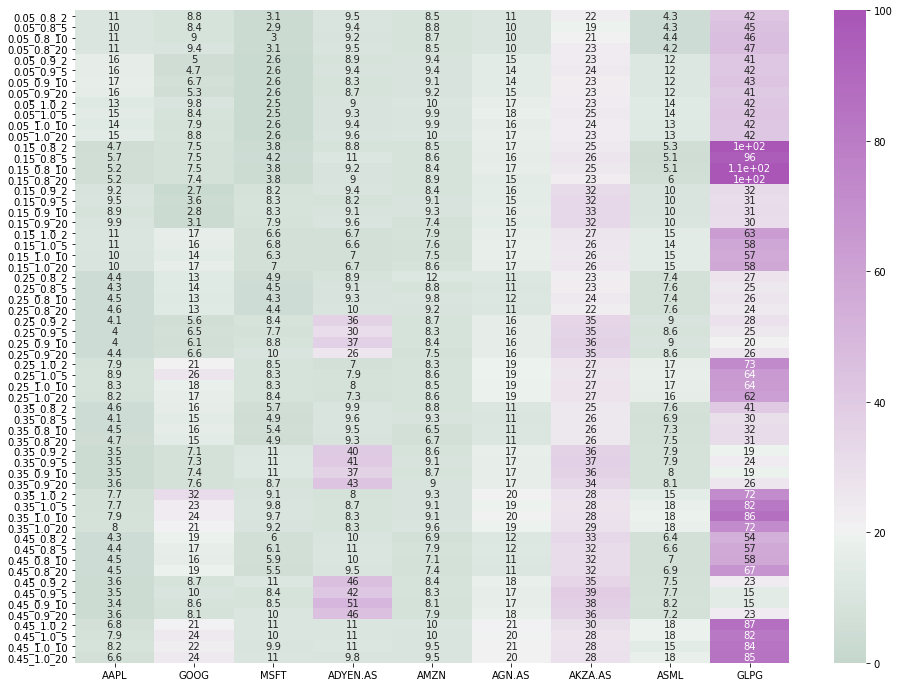

In [56]:
fig, ax = plt.subplots(figsize=(16,12)) # Sample figsize in inches

sns.heatmap(grid_df*100,
            annot=True,
            ax=ax,
            vmin=0,
            vmax=100,
            center=20,
            cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
           );


In [ ]:
for keys,values in gridsearch.items():
    for ticker, score in values.items():
        print(ticker, score)
        break
    break

## Checkout cross validation and performance metrics for prophet

In [ ]:
fbp = Prophet(daily_seasonality = True, changepoint_prior_scale=0.2) 
 # Fit the model 
fbp.fit()
# We need to specify the number of days in future
# We'll be predicting the full 2021 stock prices
fut = fbp.make_future_dataframe(periods=180) 
forecast = fbp.predict(fut)

In [ ]:
df_cv = cross_validation(fbp, initial='730 days', period='90 days', horizon='180 days')
df_cv.head()

In [ ]:
df_p = performance_metrics(df_cv)
df_p.sort_values('mape').head()

In [ ]:
# A better plot than the simple matplotlib
plot_plotly(fbp, forecast)